In [1]:
!pip install torchmetrics

In [2]:
# libraries
import pandas as pd
from pathlib import Path
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
import csv
from pathlib import Path
from torchmetrics.classification import BinaryJaccardIndex
import tqdm as tqdm
from typing import Dict, List
from tqdm.auto import tqdm
from going_modular.utils import save_model

/home/frederic/Documents/Fil_rouge/cirse/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
def robust_scale(x, eps=1e-6):
    median = np.median(x)
    mad = np.median(np.abs(x - median))
    return (x - median) / (mad + eps)

def build_label_vector(
    df_signal,
    df_peaks,
    plant_idx,
    channel,
    multiplex,
    sigma=10,
):
    molw = df_signal["molw"].values
    Y = np.zeros(len(molw), dtype=np.float32)

    dfp = df_peaks[
        (df_peaks["channel"] == channel) &
        (df_peaks["plant_id"] == plant_idx) &
        (df_peaks["multiplex"] == multiplex) &
        (df_peaks["peak_kind"] == "main")
    ]

    for _, row in dfp.iterrows():
        mu = row["mu_pb"]

        left = mu - sigma
        right = mu + sigma

        mask = (molw >= left) & (molw <= right)
        Y[mask] = 1.0

    return Y


class PeakDataset(Dataset):
    def __init__(self, csv_files):
        self.samples = []
        self.labels = []
        for csv_path in csv_files:
            df_signal = pd.read_csv(csv_path, sep=";")

            for ch in ["channel_1", "channel_2", "channel_3",
                       "channel_4"]:
                ch_idx = int(ch.split("_")[1])
                plant_idx = int(csv_path.stem.split("_pl")[-1])
                multiplex = int(csv_path.stem.split("M")[-1].split("_pl")[0])

                df_peaks = pd.read_csv("../Data/synthetic_ce_outputs/synthetic_ce_outputs_v9/peak_positions_detailed.csv",
                    sep=","
                )

                x = df_signal[ch].values.astype(np.float32)
                #print("x.shape",x.shape)
                # check length
                assert len(x) == 4961

                x = robust_scale(x)

                # shape (1, 4969)
                x = torch.from_numpy(x).unsqueeze(0)
                print(plant_idx, ch_idx, multiplex, x.shape)
                y = build_label_vector(
                    df_signal,
                    df_peaks,
                    plant_idx,
                    channel=ch_idx,
                    multiplex=multiplex
                )
                y = torch.from_numpy(y)

                self.samples.append(x)
                self.labels.append(y)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [76]:
from torch.utils.data import DataLoader

csv_files = list(Path("../Data/synthetic_ce_outputs/synthetic_ce_outputs_v9/test").glob("*.csv"))
#number of files in the folder
print(f"Number of CSV files found: {len(csv_files)}")
dataset = PeakDataset(csv_files)
x_data = dataset.samples
y_data = dataset.labels

print(len(x_data))
print(len(y_data))


Number of CSV files found: 600
118 1 1 torch.Size([1, 4961])
118 2 1 torch.Size([1, 4961])
118 3 1 torch.Size([1, 4961])
118 4 1 torch.Size([1, 4961])
528 1 1 torch.Size([1, 4961])
528 2 1 torch.Size([1, 4961])
528 3 1 torch.Size([1, 4961])
528 4 1 torch.Size([1, 4961])
202 1 1 torch.Size([1, 4961])
202 2 1 torch.Size([1, 4961])
202 3 1 torch.Size([1, 4961])
202 4 1 torch.Size([1, 4961])
30 1 1 torch.Size([1, 4961])
30 2 1 torch.Size([1, 4961])
30 3 1 torch.Size([1, 4961])
30 4 1 torch.Size([1, 4961])
306 1 1 torch.Size([1, 4961])
306 2 1 torch.Size([1, 4961])
306 3 1 torch.Size([1, 4961])
306 4 1 torch.Size([1, 4961])
187 1 1 torch.Size([1, 4961])
187 2 1 torch.Size([1, 4961])
187 3 1 torch.Size([1, 4961])
187 4 1 torch.Size([1, 4961])
277 1 1 torch.Size([1, 4961])
277 2 1 torch.Size([1, 4961])
277 3 1 torch.Size([1, 4961])
277 4 1 torch.Size([1, 4961])
588 1 1 torch.Size([1, 4961])
588 2 1 torch.Size([1, 4961])
588 3 1 torch.Size([1, 4961])
588 4 1 torch.Size([1, 4961])
128 1 1 torch

In [77]:
print(len(x_data))
print(len(y_data))

print(x_data[0].shape)
print(y_data[0].shape)

2400
2400
torch.Size([1, 4961])
torch.Size([4961])


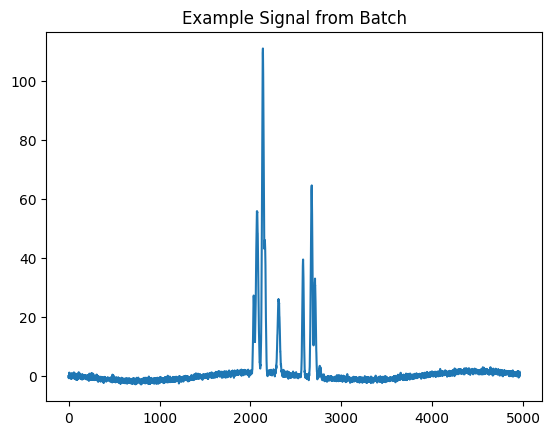

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(x_data[0][0].numpy())
plt.title("Example Signal from Batch")
plt.show()

[0. 0. 0. ... 0. 0. 0.]


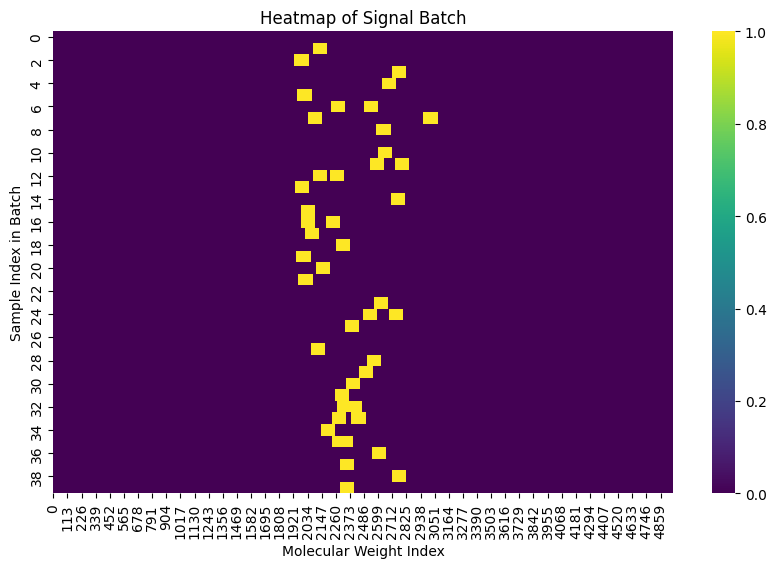

In [11]:
print(y_data[0].numpy())
plt.figure(figsize=(10, 6))
y_data = torch.stack(y_data)
sns.heatmap(y_data.numpy(), cmap="viridis", cbar=True)
plt.title("Heatmap of Signal Batch")
plt.xlabel("Molecular Weight Index")
plt.ylabel("Sample Index in Batch")
plt.show()

In [ ]:
#!pip install matplotlib

In [79]:
# train test split
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

BATCHSIZE= 32
y_data = torch.stack(y_data)
X_train, X_test, y_train, y_test = train_test_split(
    x_data,
    y_data,
    test_size=0.2,
    random_state=42
)
X_train = torch.stack(X_train)        # shape: (N, C, H, W)
#y_train = torch.stack(y_train).float()
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCHSIZE,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True
)

X_test = torch.stack(X_test)
#y_test = torch.stack(y_test).float()
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCHSIZE,
    shuffle=False,
    drop_last=False,
    num_workers=4,
    pin_memory=True
)

In [80]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(type(X_train))
print(type(X_train[0]))

1920
1920
480
480
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [17]:
print(type(y_train))
print(type(y_test))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [81]:
class down_block(nn.Module):
    def __init__(self, in_channel,out_channel,kernel, padding,stride):
        super().__init__()
        self.conv = nn.Conv1d(in_channel, out_channel, kernel_size=kernel, padding=padding, stride=stride)
        self.norm = nn.BatchNorm1d(out_channel)
        self.block = nn.Sequential(
            self.conv,
            self.norm,
            nn.LeakyReLU(0.25)
        )
    
    def forward(self, x):
        print(x.shape)
        x = self.block(x)
        print(x.shape)
        return x

class up_block(nn.Module):
    def __init__(self,in_channel,out_channel,kernel, padding,stride, apply_Dropout=True):
        super().__init__()
        self.conv = nn.Conv1d(in_channel, out_channel, kernel_size=kernel, stride=1)
        self.refine = nn.Conv1d(out_channel * 2, out_channel, kernel_size=kernel, padding=padding, stride=1)
        self.norm = nn.BatchNorm1d(out_channel)
        #post concatenation
        self.post = nn.Sequential(
            self.refine, #non linearity after concatenation
            self.norm,
            nn.Dropout(0.25) if apply_Dropout else nn.Identity(),
            nn.LeakyReLU(0.25)
        )

    def forward(self, x1,skip):
        print("x1 before up block", x1.shape)
        print("x2 before up block", skip.shape)
        x1 = nn.functional.interpolate(x1, size=skip.shape[-1], mode="linear", align_corners=False)
        x1 = self.conv(x1)
        if x1.shape[-1] != skip.shape[-1]:
            diff = x1.shape[-1] - skip.shape[-1]
            x1 = x1[..., diff//2 : diff//2 + skip.shape[-1]] # centered cropping Ronneberger et al., 2015
        #concatenation
        print(x1.shape)
        print(skip.shape)
        x = torch.cat([skip, x1], dim=1)
        x = self.post(x)
        return x

class U_net(nn.Module):
    def __init__(self, in_channel,hidden_unit,out_channel,list_kernel, apply_Dropout=True):
        super().__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        for i in range(len(list_kernel)):
            pad = list_kernel[i]//2
            self.downs.append(down_block(in_channel, hidden_unit, kernel=list_kernel[i], padding=pad, stride=2))
            in_channel = hidden_unit
        list_kernel = list_kernel[::-1]
        for i in range(len(list_kernel)-1):
            pad = list_kernel[i]//2
            self.ups.append(up_block(hidden_unit, hidden_unit, kernel=list_kernel[i], padding=pad, stride=2, apply_Dropout=apply_Dropout))
        self.final = nn.Conv1d(hidden_unit, out_channel, kernel_size=1)
    
    def forward(self, x):
        skip = []  # stockage des skips pour le decoder

        print("=== Encoder ===")
        for i, down in enumerate(self.downs):
            print(f"Input to down[{i}]:", x.shape)
            x = down(x)
            print(f"Output from down[{i}]:", x.shape)
            skip.append(x)

        print("Encoder done. Bottleneck:", x.shape)
        print("Skip list sizes before removing bottleneck:", [s.shape for s in skip])

        # On enlève le bottleneck des skips
        skip = skip[:-1]
        skip = skip[::-1]  # pour correspondre à l’ordre des up_blocks
        print("Skip list after removing bottleneck and reversing:", [s.shape for s in skip])

        print("=== Decoder ===")
        for i, up in enumerate(self.ups):
            print(f"\n--- Up block {i} ---")
            print("x1 (input to up block, BEFORE interpolate):", x.shape)
            print("x2 (skip connection):", skip[i].shape)

            # Upsample x1 pour matcher x2
            x1_interpolated = nn.functional.interpolate(x, size=skip[i].shape[-1], mode="linear", align_corners=False)
            print("x1 AFTER interpolate:", x1_interpolated.shape)

            # Concatenate
            x = torch.cat([skip[i], x1_interpolated], dim=1)
            print("After concat:", x.shape)

            # Post-processing
            x = up.post(x)
            print("After post-processing:", x.shape)

        # Final upsample pour s'assurer que la sortie = input
        x = nn.functional.interpolate(x, size=4961, mode="linear", align_corners=False)
        x = self.final(x).squeeze(1)
        print("\nFinal output:", x.shape)

        return x # output : [10, 4961]

In [ ]:
# other model
# https://www.nature.com/articles/s41598-020-64655-4

In [ ]:
#!pip install torchmetrics

In [ ]:
#Metrics 
# https://arxiv.org/pdf/2101.01666
# https://arxiv.org/pdf/1505.04597

In [87]:
from pathlib import Path
net = U_net(
    in_channel=1,
    hidden_unit=10,
    out_channel=1,
    list_kernel=[9,9,6,6,3,3],
    apply_Dropout=True
)
# 1. Create models directory 
MODEL_PATH = Path("../Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = f"pytorch_workflow_unet.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=net.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: ../Models/pytorch_workflow_unet.pth


In [83]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn,
               metric,
               optimizer,
               device):
    
    model.train()
    metric.reset()
    full_loss, counts = 0, 0
    
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # y_batch = torch.stack(y_batch).float()
        logits = model(x_batch)

        optimizer.zero_grad()
        loss = loss_fn(logits, y_batch.float())
        loss.backward()
        optimizer.step()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()
        
        # Metrics
        full_loss += loss.item() * x_batch.size(0)
        # size issues?
        metric.update(preds.squeeze(1), y_batch.int())
        counts += x_batch.size(0)
    score = metric.compute()
    metric.reset()
    return full_loss, score, counts
    

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn,
              metric,
              device):
    model.eval()
    metric.reset()
    with torch.no_grad():
                full_loss, counts = 0, 0
                for x_test,y_test in dataloader:
                    
                    print(x_test.shape)
                    print(x_test.size(0))
                    
                    x_test,y_test = x_test.to(device), y_test.to(device)
                    # y_test = torch.stack(y_test).float()
                    y_logits = model(x_test)
                    probs = torch.sigmoid(y_logits)
                    preds = (probs > 0.5).int()
                    loss = loss_fn(y_logits, y_test.float())
                    full_loss += loss.item() * x_test.size(0)
                    metric.update(preds.squeeze(1), y_test.int().squeeze(1))
                    counts += x_test.size(0)
    score = metric.compute()
    metric.reset()
    return full_loss, score, counts

In [84]:
def train_test(model: torch.nn.Module, 
          train_loader: torch.utils.data.DataLoader, 
          test_loader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
               metric,
          epochs: int,
          device: torch.device):
    # device
    net.to(device)

    # Save model
    # 1. Create models directory 
    MODEL_PATH = Path("../Models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    for epoch in tqdm(range(epochs)):
        #print(f"[INFO] Model: {model}")
        #print(f"[INFO] DataLoader: {dataloader_name}")
        print(f"[INFO] Number of epochs: {epochs}")

        # Training loop
        train_loss, train_score, train_counts = train_step(model=model,
                                            dataloader=train_loader,
                                            loss_fn=loss_fn,
                                            metric=metric,
                                            optimizer=optimizer,
                                            device=device)
        print(f"[INFO] train loss: {train_loss}")
        print(f"[INFO] train metrics: {train_score}")
        print(f"[INFO] train counts: {train_counts}")

        if epoch % 1 == 0:
            #Test loop
            test_loss, test_score, test_counts = test_step(model=model,
                                            dataloader=test_loader,
                                            loss_fn=loss_fn,
                                            metric=metric,
                                            device=device)
            print(f"[INFO] test loss: {test_loss}")
            print(f"[INFO] test metrics: {test_score}")
            print(f"[INFO] test counts: {test_counts}")
        if epoch % 5 == 0:
            # 2. Create model save path 
            MODEL_NAME = f"{epoch}_pytorch_workflow_unet.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

            # 3. Save the model state dict 
            print(f"Saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=net.state_dict(), # only saving the state_dict() only saves the models learned parameters
                    f=MODEL_SAVE_PATH)

In [88]:
net = U_net(
    in_channel=1,
    hidden_unit=10,
    out_channel=1,
    list_kernel=[9,9,6,6,3,3],
    apply_Dropout=True
)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# Metrics
metric = metric = BinaryJaccardIndex()
epochs = 10

train_test(model=net, 
          train_loader=train_loader, 
          test_loader=test_loader, 
          optimizer=optimizer,
          loss_fn=loss_fn,
               metric=metric,
          epochs=epochs,
          device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
torch.Size([32, 10, 156])
torch.Size([32, 10, 78])
Output from down[5]: torch.Size([32, 10, 78])
Encoder done. Bottleneck: torch.Size([32, 10, 78])
Skip list sizes before removing bottlenec

 10%|█         | 1/10 [00:21<03:10, 21.17s/it]

[INFO] test loss: 179.60201740264893
[INFO] test metrics: 0.5683499574661255
[INFO] test counts: 480
Saving model to: ../Models/0_pytorch_workflow_unet.pth
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
torch.Size([32, 10, 156])
torch.S

 20%|██        | 2/10 [00:43<02:53, 21.72s/it]

[INFO] test loss: 136.3805227279663
[INFO] test metrics: 0.6241683959960938
[INFO] test counts: 480
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
torch.Size([32, 10, 156])
torch.Size([32, 10, 78])
Output from down[5]: torch.Size([32, 1

 30%|███       | 3/10 [01:06<02:36, 22.29s/it]

After post-processing: torch.Size([32, 10, 2481])

Final output: torch.Size([32, 4961])
[INFO] test loss: 99.22072839736938
[INFO] test metrics: 0.6417620778083801
[INFO] test counts: 480
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
t

 40%|████      | 4/10 [01:29<02:15, 22.52s/it]

After post-processing: torch.Size([32, 10, 1242])

--- Up block 4 ---
x1 (input to up block, BEFORE interpolate): torch.Size([32, 10, 1242])
x2 (skip connection): torch.Size([32, 10, 2481])
x1 AFTER interpolate: torch.Size([32, 10, 2481])
After concat: torch.Size([32, 20, 2481])
After post-processing: torch.Size([32, 10, 2481])

Final output: torch.Size([32, 4961])
[INFO] test loss: 72.46772193908691
[INFO] test metrics: 0.6370308995246887
[INFO] test counts: 480
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.S

 50%|█████     | 5/10 [01:49<01:48, 21.74s/it]

[INFO] test loss: 54.22442865371704
[INFO] test metrics: 0.6433225274085999
[INFO] test counts: 480
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
torch.Size([32, 10, 156])
torch.Size([32, 10, 78])
Output from down[5]: torch.Size([32, 1

 60%|██████    | 6/10 [02:10<01:26, 21.52s/it]

[INFO] test loss: 43.74632000923157
[INFO] test metrics: 0.649200439453125
[INFO] test counts: 480
Saving model to: ../Models/5_pytorch_workflow_unet.pth
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
torch.Size([32, 10, 156])
torch.Siz

 70%|███████   | 7/10 [02:33<01:06, 22.04s/it]

[INFO] test loss: 34.034571170806885
[INFO] test metrics: 0.6537079215049744
[INFO] test counts: 480
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
torch.Size([32, 10, 156])
torch.Size([32, 10, 78])
Output from down[5]: torch.Size([32, 

 80%|████████  | 8/10 [02:54<00:43, 21.70s/it]

[INFO] test loss: 29.517484426498413
[INFO] test metrics: 0.6483576893806458
[INFO] test counts: 480
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
torch.Size([32, 10, 156])
torch.Size([32, 10, 78])
Output from down[5]: torch.Size([32, 

 90%|█████████ | 9/10 [03:15<00:21, 21.36s/it]


Final output: torch.Size([32, 4961])
[INFO] test loss: 25.26618790626526
[INFO] test metrics: 0.642474889755249
[INFO] test counts: 480
[INFO] Number of epochs: 10
=== Encoder ===
Input to down[0]: torch.Size([32, 1, 4961])
torch.Size([32, 1, 4961])
torch.Size([32, 10, 2481])
Output from down[0]: torch.Size([32, 10, 2481])
Input to down[1]: torch.Size([32, 10, 2481])
torch.Size([32, 10, 2481])
torch.Size([32, 10, 1241])
Output from down[1]: torch.Size([32, 10, 1241])
Input to down[2]: torch.Size([32, 10, 1241])
torch.Size([32, 10, 1241])
torch.Size([32, 10, 621])
Output from down[2]: torch.Size([32, 10, 621])
Input to down[3]: torch.Size([32, 10, 621])
torch.Size([32, 10, 621])
torch.Size([32, 10, 311])
Output from down[3]: torch.Size([32, 10, 311])
Input to down[4]: torch.Size([32, 10, 311])
torch.Size([32, 10, 311])
torch.Size([32, 10, 156])
Output from down[4]: torch.Size([32, 10, 156])
Input to down[5]: torch.Size([32, 10, 156])
torch.Size([32, 10, 156])
torch.Size([32, 10, 78])
O

100%|██████████| 10/10 [03:35<00:00, 21.55s/it]

[INFO] test loss: 22.49266743659973
[INFO] test metrics: 0.660420298576355
[INFO] test counts: 480
